In [1]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, TimeDistributed, Bidirectional
import tensorflow as tf

2024-07-11 11:15:18.313114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 11:15:18.313223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 11:15:18.451174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load data
df = pd.read_csv('/kaggle/input/res-train-val/Restaurants_Train - Copy.csv')

In [3]:
# Sử dụng tokenizer từ BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# Xử lý dữ liệu đầu vào (raw_text)
sentences = df['raw_text'].tolist()
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

In [5]:
# Xử lý dữ liệu đầu ra (aspectTerms)
aspect_terms = df['aspectTerms'].apply(eval)

# Chuyển đổi polarity thành giá trị số
polarity_dict = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': 3, 'conflict': 4}

In [6]:
# Tạo danh sách các nhãn (term, polarity)
labels_token_ids = []
labels_polarity = []

for i, aspect_list in enumerate(aspect_terms):
    label_token_ids = [0] * len(input_ids[i])
    label_polarity = [3] * len(input_ids[i])  
    
    for aspect in aspect_list:
        term = aspect['term']
        polarity = aspect['polarity']
        
        token_ids = tokenizer.encode(term, add_special_tokens=False)
        for j in range(len(input_ids[i]) - len(token_ids) + 1):
            if input_ids[i][j:j+len(token_ids)] == token_ids:
                label_token_ids[j] = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(term))[0]
                label_polarity[j:j+len(token_ids)] = [polarity_dict[polarity]] * len(token_ids)
    
    labels_token_ids.append(label_token_ids)
    labels_polarity.append(label_polarity)

In [7]:
# Pad sequences
max_len = max(len(ids) for ids in input_ids)
input_ids_padded = pad_sequences(input_ids, maxlen=max_len, dtype='int32', padding='post')
labels_token_ids_padded = pad_sequences(labels_token_ids, maxlen=max_len, dtype='int32', padding='post')
labels_polarity_padded = pad_sequences(labels_polarity, maxlen=max_len, dtype='int32', padding='post')
labels_polarity_one_hot = to_categorical(labels_polarity_padded, num_classes=5)

In [32]:
# Xây dựng mô hình ABSA bằng Keras
vocab_size = len(tokenizer)
embedding_dim = 100

input_text = Input(shape=(max_len,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_text)
lstm_layer = Bidirectional(LSTM(250, return_sequences=True))(embedding_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
output_term = TimeDistributed(Dense(vocab_size, activation='softmax'), name='output_term')(dropout_layer)  # Predict term
output_polarity = TimeDistributed(Dense(5, activation='softmax'), name='output_polarity')(dropout_layer)  # Predict polarity

In [33]:
model = Model(inputs=input_text, outputs=[output_term, output_polarity])
model.compile(optimizer='adam',
              loss={'output_term': 'sparse_categorical_crossentropy', 'output_polarity': 'categorical_crossentropy'},
              metrics={'output_term': 'accuracy', 'output_polarity': 'accuracy'})

In [34]:
# Huấn luyện mô hình
history = model.fit(input_ids_padded, {'output_term': labels_token_ids_padded, 'output_polarity': labels_polarity_one_hot},
          epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - loss: 4.0551 - output_polarity_accuracy: 0.8861 - output_term_accuracy: 0.8597 - val_loss: 0.1824 - val_output_polarity_accuracy: 0.9802 - val_output_term_accuracy: 0.9896
Epoch 2/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - loss: 0.2256 - output_polarity_accuracy: 0.9767 - output_term_accuracy: 0.9872 - val_loss: 0.1630 - val_output_polarity_accuracy: 0.9802 - val_output_term_accuracy: 0.9896
Epoch 3/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - loss: 0.2055 - output_polarity_accuracy: 0.9761 - output_term_accuracy: 0.9867 - val_loss: 0.1379 - val_output_polarity_accuracy: 0.9846 - val_output_term_accuracy: 0.9896
Epoch 4/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - loss: 0.1607 - output_polarity_accuracy: 0.9840 - output_term_accuracy: 0.9866 - val_loss: 0.1259 - val_output_polarity_accuracy: 0.9860 - val_output_term_accuracy: 0.9899
Epoch 5/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - loss: 0.1348 - output_polar

In [35]:
# Đánh giá mô hình
test_df = pd.read_csv('/kaggle/input/res-test/Restaurants_Test.csv')
test_sentences = test_df['raw_text'].tolist()
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
test_input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in test_tokenized_texts]
test_input_ids_padded = pad_sequences(test_input_ids, maxlen=max_len, dtype='int32', padding='post')

In [36]:
# Preprocess output data (aspectTerms)
test_aspect_terms = test_df['aspectTerms'].apply(eval)
test_term_polarity_list = [[(term['term'], term['polarity']) for term in aspect_list] for aspect_list in test_aspect_terms]

# Prepare output data for model
test_labels_token_ids = np.zeros((len(test_term_polarity_list), max_len), dtype='int32')
test_labels_polarity = np.zeros((len(test_term_polarity_list), max_len), dtype='int32')

for i, term_polarity in enumerate(test_term_polarity_list):
    for j, (term, polarity) in enumerate(term_polarity):
        token_ids = tokenizer.encode(term, add_special_tokens=False)
        if token_ids:
            test_labels_token_ids[i, j] = token_ids[0]
        test_labels_polarity[i, j] = polarity_dict[polarity]

In [37]:
# Padding sequences
test_input_ids_padded = pad_sequences(test_input_ids, maxlen=max_len, dtype='int32', padding='post')
test_labels_polarity_one_hot = to_categorical(test_labels_polarity, num_classes=5)

In [38]:
# Evaluate the model
evaluation_results = model.evaluate(test_input_ids_padded,
                                    {'output_term': test_labels_token_ids, 'output_polarity': test_labels_polarity_one_hot})

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 2.4733 - output_polarity_accuracy: 0.8313 - output_term_accuracy: 0.9730


In [39]:
# Print evaluation results
if len(evaluation_results) == 3:
    test_loss, test_output_term_accuracy, test_output_polarity_accuracy = evaluation_results
    print(f"Test Loss: {test_loss}")
    print(f"Test Term Accuracy: {test_output_term_accuracy}")
    print(f"Test Polarity Accuracy: {test_output_polarity_accuracy}")
else:
    test_loss, test_output_term_loss, test_output_polarity_loss, test_output_term_accuracy, test_output_polarity_accuracy = evaluation_results
    print(f"Test Loss: {test_loss}")
    print(f"Test Term Loss: {test_output_term_loss}")
    print(f"Test Polarity Loss: {test_output_polarity_loss}")
    print(f"Test Term Accuracy: {test_output_term_accuracy}")
    print(f"Test Polarity Accuracy: {test_output_polarity_accuracy}")

Test Loss: 2.6893157958984375
Test Term Accuracy: 0.814652681350708
Test Polarity Accuracy: 0.9710695147514343


In [40]:
# In mô hình để kiểm tra kiến trúc
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 90, 100)   │  3,052,200 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 90, 500)   │    702,000 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 90, 500)   │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_term         │ (None, 90, 30522) │ 15,291,522 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_polarity     │ (None, 90, 5)     │      2,505 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,144,683 (217.99 MB)

 Trainable params: 19,048,227 (72.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,096,456 (145.33 MB)

In [41]:
import numpy as np

# Hàm để dự đoán các term và polarity
def predict(sentence):
    tokenized_text = tokenizer.tokenize(sentence)
    input_id = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_id_padded = pad_sequences([input_id], maxlen=max_len, dtype='int32', padding='post')

    predictions = model.predict(input_id_padded)
    term_preds = np.argmax(predictions[0], axis=-1)[0]
    polarity_preds = np.argmax(predictions[1], axis=-1)[0]

    term_tokens = []
    polarities = []
    for i in range(len(term_preds)):
        if term_preds[i] != 0:
            term_tokens.append(tokenizer.convert_ids_to_tokens([term_preds[i]])[0])
            polarities.append(reverse_polarity_dict[polarity_preds[i]])

    return list(zip(term_tokens, polarities))

reverse_polarity_dict = {v: k for k, v in polarity_dict.items()}

In [49]:
test_sentence = " Porridge: there are many flavors for you to choose from,\\ but I choose pandan leaf flavor. The porridge is about\\ the size of two cups, the porridge is quite smooth\\ and fragrant, the porridge has a natural rice scent\\ "
predictions = predict(test_sentence)
print(f"Sentence: {test_sentence}")
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sentence:  Porridge: there are many flavors for you to choose from,\ but I choose pandan leaf flavor. The porridge is about\ the size of two cups, the porridge is quite smooth\ and fragrant, the porridge has a natural rice scent\ 
Predictions: [('people', 'negative'), ('rice', 'negative')]


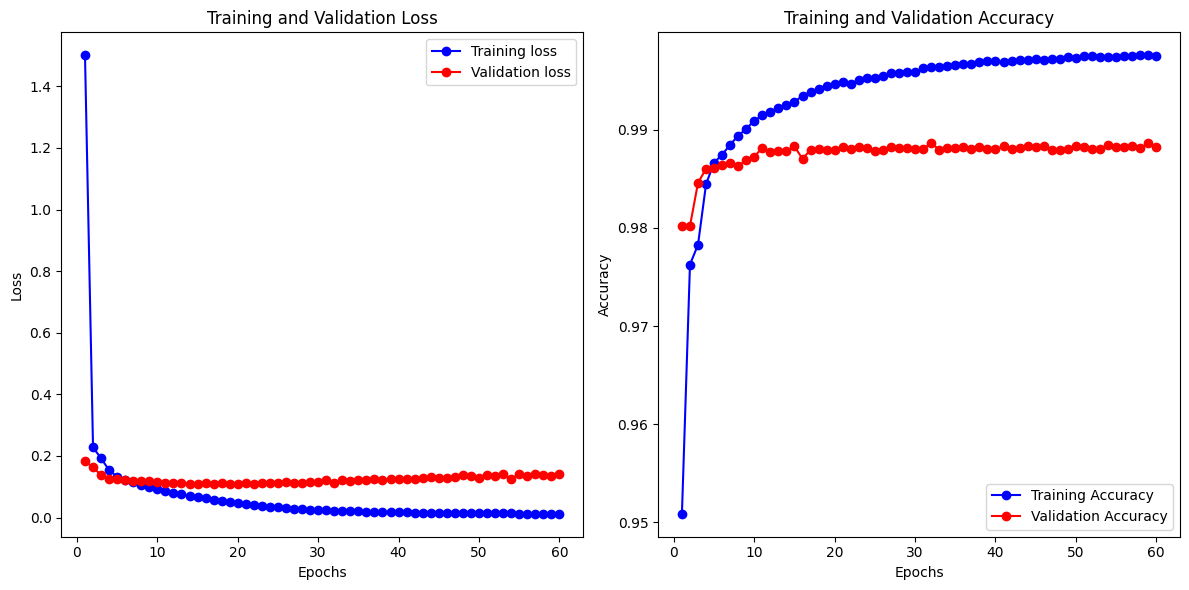

In [43]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['output_polarity_accuracy']
val_accuracy = history_dict['val_output_polarity_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
